<a href="https://colab.research.google.com/github/Puspak-404/SecureScope/blob/main/SecureScope_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df1=pd.read_excel('/content/drive/MyDrive/Global_Dataset.xlsx')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169566 entries, 0 to 169565
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ID           169566 non-null  int64  
 1   CVE-ID       169566 non-null  object 
 2   CVSS-V3      95559 non-null   float64
 3   CVSS-V2      169461 non-null  float64
 4   SEVERITY     169480 non-null  object 
 5   DESCRIPTION  169566 non-null  object 
 6   CWE-ID       169566 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 9.1+ MB


In [ ]:
kaggle_df=pd.read_csv('/content/drive/MyDrive/cve_cisa_epss_enriched_dataset.csv')
mapping_df=pd.read_excel('/content/drive/MyDrive/Global_Dataset.xlsx')
zap_df=pd.read_csv('/content/drive/MyDrive/vulnerability_dataset.csv')

In [ ]:
try:
    df = pd.read_csv('cve_cisa_epss_enriched_dataset.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'cve_cisa_epss_enriched_dataset.csv' not found. Please upload the file.")
    exit()

print("\n--- Dataset Info ---")
df.info()


Dataset loaded successfully.

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154468 entries, 0 to 154467
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cve_id                  154468 non-null  object 
 1   base_severity           154468 non-null  object 
 2   base_score              154468 non-null  float64
 3   exploitability_score    154468 non-null  float64
 4   impact_score            154468 non-null  float64
 5   epss_score              154468 non-null  float64
 6   epss_perc               154468 non-null  float64
 7   cisa_kev                154468 non-null  bool   
 8   attack_vector           154468 non-null  object 
 9   attack_complexity       154468 non-null  object 
 10  privileges_required     154468 non-null  object 
 11  user_interaction        154468 non-null  object 
 12  scope                   154468 non-null  object 
 13  confidentiality_impact 

In [ ]:
print("\n--- Target Variable Distribution (cisa_kev) ---")
print(df['cisa_kev'].value_counts())
print(f"Percentage of KEVs (True): {df['cisa_kev'].mean() * 100:.2f}%")



--- Target Variable Distribution (cisa_kev) ---
cisa_kev
False    153511
True        957
Name: count, dtype: int64
Percentage of KEVs (True): 0.62%


In [ ]:
X = df.drop(['cve_id', 'published_date', 'cisa_kev'], axis=1) # Drop ID and date, and the target itself
y = df['cisa_kev']

In [ ]:
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")



Numerical Features: ['base_score', 'exploitability_score', 'impact_score', 'epss_score', 'epss_perc']
Categorical Features: ['base_severity', 'attack_vector', 'attack_complexity', 'privileges_required', 'user_interaction', 'scope', 'confidentiality_impact', 'integrity_impact', 'availability_impact']


In [ ]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Proportion of KEVs in training set: {y_train.mean():.4f}")
print(f"Proportion of KEVs in test set: {y_test.mean():.4f}")



Training set size: 123574 samples
Test set size: 30894 samples
Proportion of KEVs in training set: 0.0062
Proportion of KEVs in test set: 0.0062


In [ ]:
print("\n" + "="*50)
print("--- Training Logistic Regression Model ---")
print("="*50)


--- Training Logistic Regression Model ---


In [ ]:
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000))])

# Train the Logistic Regression model
model_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test)
y_proba_lr = model_lr.predict_proba(X_test)[:, 1] # Probability of being True (KEV)


In [ ]:
print("\nLogistic Regression Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix (Logistic Regression):")
print(cm_lr)



Logistic Regression Evaluation:
Accuracy: 0.8941
ROC AUC Score: 0.9547

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.89      0.94     30703
        True       0.05      0.87      0.09       191

    accuracy                           0.89     30894
   macro avg       0.52      0.88      0.52     30894
weighted avg       0.99      0.89      0.94     30894


Confusion Matrix (Logistic Regression):
[[27455  3248]
 [   24   167]]


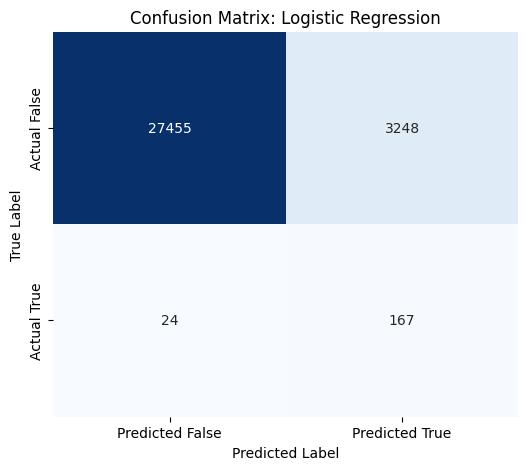

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted False', 'Predicted True'],
            yticklabels=['Actual False', 'Actual True'])
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
false_positives_lr_indices = np.where((y_test == False) & (y_pred_lr == True))[0]
false_positives_lr_data = X_test.iloc[false_positives_lr_indices]

print(f"\nNumber of False Positives (Logistic Regression): {len(false_positives_lr_indices)}")
if not false_positives_lr_data.empty:
    print("\nExample False Positives (Logistic Regression - first 5 rows):")
    print(false_positives_lr_data.head())
else:
    print("No False Positives found for Logistic Regression in the test set.")



Number of False Positives (Logistic Regression): 3248

Example False Positives (Logistic Regression - first 5 rows):
       base_severity  base_score  exploitability_score  impact_score  \
95299         MEDIUM         5.5                   1.8           3.6   
97481           HIGH         8.8                   2.8           5.9   
141172          HIGH         7.5                   1.6           5.9   
10820         MEDIUM         4.3                   2.8           1.4   
134867          HIGH         7.2                   1.2           5.9   

        epss_score  epss_perc attack_vector attack_complexity  \
95299      0.00755    0.72272         LOCAL               LOW   
97481      0.08903    0.92193       NETWORK               LOW   
141172     0.17011    0.94700       NETWORK              HIGH   
10820      0.86748    0.99383       NETWORK               LOW   
134867     0.07059    0.91108       NETWORK               LOW   

       privileges_required user_interaction      scope con

XGBoost

In [ ]:
print("\n" + "="*50)
print("--- Training XGBoost Classifier Model ---")
print("="*50)

# For XGBoost, it's good practice to encode the target if it's boolean/string
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)



--- Training XGBoost Classifier Model ---


In [ ]:
scale_pos_weight_val = (y_train_encoded == 0).sum() / (y_train_encoded == 1).sum()
print(f"XGBoost scale_pos_weight: {scale_pos_weight_val:.2f}")

model_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', XGBClassifier(objective='binary:logistic',
                                                         eval_metric='logloss',
                                                         use_label_encoder=False,
                                                         random_state=42,
                                                         n_estimators=100,
                                                         learning_rate=0.1,
                                                         scale_pos_weight=scale_pos_weight_val))])

# Train the XGBoost model
model_xgb.fit(X_train, y_train_encoded)

# Make predictions
y_pred_xgb_encoded = model_xgb.predict(X_test)
y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1] # Probability of being True (KEV)

# Decode predictions back to original labels for evaluation
y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)
y_test_original = label_encoder.inverse_transform(y_test_encoded) # Use original y_test for comparison

# Evaluate XGBoost
print("\nXGBoost Classifier Evaluation:")
print(f"Accuracy: {accuracy_score(y_test_original, y_pred_xgb):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test_original, y_proba_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_original, y_pred_xgb))


XGBoost scale_pos_weight: 160.32


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:20:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classifier Evaluation:
Accuracy: 0.9154
ROC AUC Score: 0.9521

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.92      0.96     30703
        True       0.06      0.85      0.11       191

    accuracy                           0.92     30894
   macro avg       0.53      0.88      0.53     30894
weighted avg       0.99      0.92      0.95     30894




Confusion Matrix (XGBoost):
[[28119  2584]
 [   29   162]]


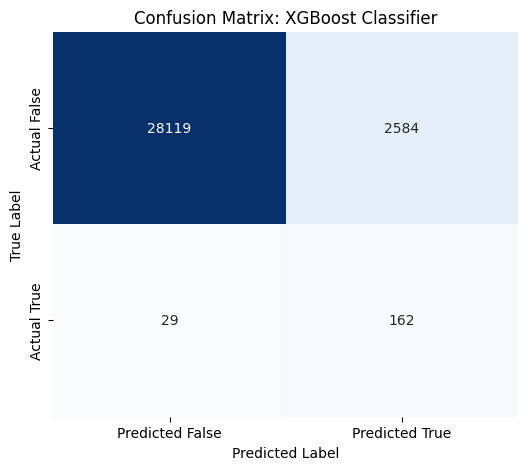


Number of False Positives (XGBoost): 2584

Example False Positives (XGBoost - first 5 rows):
       base_severity  base_score  exploitability_score  impact_score  \
77727           HIGH         7.5                   3.9           3.6   
134177          HIGH         8.8                   2.8           5.9   
97481           HIGH         8.8                   2.8           5.9   
141172          HIGH         7.5                   1.6           5.9   
10820         MEDIUM         4.3                   2.8           1.4   

        epss_score  epss_perc attack_vector attack_complexity  \
77727      0.11156    0.93200       NETWORK               LOW   
134177     0.00056    0.17424       NETWORK               LOW   
97481      0.08903    0.92193       NETWORK               LOW   
141172     0.17011    0.94700       NETWORK              HIGH   
10820      0.86748    0.99383       NETWORK               LOW   

       privileges_required user_interaction      scope confidentiality_impact  \
7

In [ ]:
cm_xgb = confusion_matrix(y_test_original, y_pred_xgb)
print("\nConfusion Matrix (XGBoost):")
print(cm_xgb)

# Plotting Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted False', 'Predicted True'],
            yticklabels=['Actual False', 'Actual True'])
plt.title('Confusion Matrix: XGBoost Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Identify False Positives for XGBoost
# False Positives: Actual is False (not KEV), Predicted is True (is KEV)
false_positives_xgb_indices = np.where((y_test_original == False) & (y_pred_xgb == True))[0]
false_positives_xgb_data = X_test.iloc[false_positives_xgb_indices]

print(f"\nNumber of False Positives (XGBoost): {len(false_positives_xgb_indices)}")
if not false_positives_xgb_data.empty:
    print("\nExample False Positives (XGBoost - first 5 rows):")
    print(false_positives_xgb_data.head())
else:
    print("No False Positives found for XGBoost in the test set.")



--- Training XGBoost Classifier Model ---
XGBoost scale_pos_weight: 160.32


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:20:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classifier Evaluation:
Accuracy: 0.9154
ROC AUC Score: 0.9521

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.92      0.96     30703
        True       0.06      0.85      0.11       191

    accuracy                           0.92     30894
   macro avg       0.53      0.88      0.53     30894
weighted avg       0.99      0.92      0.95     30894


Confusion Matrix (XGBoost):
[[28119  2584]
 [   29   162]]


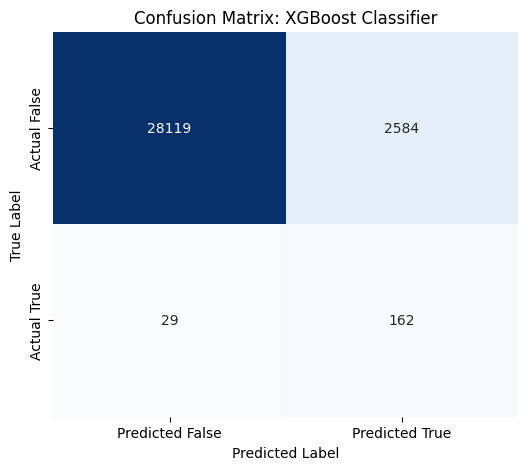


Number of False Positives (XGBoost): 2584

Example False Positives (XGBoost - first 5 rows):
   base_severity  base_score  exploitability_score  impact_score  epss_score  \
4           HIGH         7.5                   3.9           3.6     0.11156   
8           HIGH         8.8                   2.8           5.9     0.00056   
13          HIGH         8.8                   2.8           5.9     0.08903   
23          HIGH         7.5                   1.6           5.9     0.17011   
43        MEDIUM         4.3                   2.8           1.4     0.86748   

    epss_perc attack_vector attack_complexity privileges_required  \
4     0.93200       NETWORK               LOW                NONE   
8     0.17424       NETWORK               LOW                NONE   
13    0.92193       NETWORK               LOW                 LOW   
23    0.94700       NETWORK              HIGH                 LOW   
43    0.99383       NETWORK               LOW                NONE   

   user_in

In [ ]:
## --- Model 2: XGBoost Classifier ---
print("\n" + "="*50)
print("--- Training XGBoost Classifier Model ---")
print("="*50)

# For XGBoost, it's good practice to encode the target if it's boolean/string
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
# Assuming X_train, X_test, y_train, y_test are defined from previous cells
# If not, you might need to include the data loading and splitting steps here as well.

label_encoder = LabelEncoder()
# Ensure y_train is available before fitting the encoder
if 'y_train' not in locals():
    print("Error: y_train is not defined. Please run the data splitting cell first.")
else:
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Create a pipeline for XGBoost Classifier
    # 'scale_pos_weight' can help with imbalanced datasets.
    # Calculate it as count(negative examples) / count(positive examples)
    scale_pos_weight_val = (y_train_encoded == 0).sum() / (y_train_encoded == 1).sum()
    print(f"XGBoost scale_pos_weight: {scale_pos_weight_val:.2f}")

    model_xgb = Pipeline(steps=[('preprocessor', preprocessor), # Assuming 'preprocessor' is defined
                                ('classifier', XGBClassifier(objective='binary:logistic',
                                                             eval_metric='logloss',
                                                             use_label_encoder=False,
                                                             random_state=42,
                                                             n_estimators=100,
                                                             learning_rate=0.1,
                                                             scale_pos_weight=scale_pos_weight_val))])

    # Train the XGBoost model
    model_xgb.fit(X_train, y_train_encoded)

    # Make predictions
    y_pred_xgb_encoded = model_xgb.predict(X_test)
    y_proba_xgb = model_xgb.predict_proba(X_test)[:, 1] # Probability of being True (KEV)

    # Decode predictions back to original labels for evaluation
    y_test_original = label_encoder.inverse_transform(y_test_encoded) # Use original y_test for comparison
    y_pred_xgb = label_encoder.inverse_transform(y_pred_xgb_encoded)


    # Evaluate XGBoost
    print("\nXGBoost Classifier Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test_original, y_pred_xgb):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_test_original, y_proba_xgb):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test_original, y_pred_xgb))

    # Confusion Matrix for XGBoost
    cm_xgb = confusion_matrix(y_test_original, y_pred_xgb)
    print("\nConfusion Matrix (XGBoost):")
    print(cm_xgb)

    # Plotting Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted False', 'Predicted True'],
                yticklabels=['Actual False', 'Actual True'])
    plt.title('Confusion Matrix: XGBoost Classifier')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Identify False Positives for XGBoost
    # False Positives: Actual is False (not KEV), Predicted is True (is KEV)
    # Reset index for safe comparison and selection
    X_test_reset = X_test.reset_index(drop=True)
    y_test_original_series = pd.Series(y_test_original).reset_index(drop=True)
    y_pred_xgb_series = pd.Series(y_pred_xgb).reset_index(drop=True)


    false_positives_xgb_indices = np.where((y_test_original_series == False) & (y_pred_xgb_series == True))[0]
    false_positives_xgb_data = X_test_reset.iloc[false_positives_xgb_indices]

    print(f"\nNumber of False Positives (XGBoost): {len(false_positives_xgb_indices)}")
    if not false_positives_xgb_data.empty:
        print("\nExample False Positives (XGBoost - first 5 rows):")
        print(false_positives_xgb_data.head())
    else:
        print("No False Positives found for XGBoost in the test set.")

ZAP scas with CVE and CWE Maping snippets required

In [ ]:
# ========================================================================
#   Final Merging Script for ZAP, CVE, and Mapping Data in Google Colab
# ========================================================================

import pandas as pd
from google.colab import files # Import the 'files' module

# --- 1. Define the filenames you uploaded ---
ZAP_FILE = 'vulnerability_dataset.csv'
KAGGLE_CVE_FILE = '/content/cve_cisa_epss_enriched_dataset.csv'
# This is the specific name of the file from the Kaggle link you provided
MAPPING_FILE = '/content/Global_Dataset.xlsx'

# --- 2. Load all three datasets ---
print("--- Loading All Datasets ---")
try:
    zap_df = pd.read_csv(ZAP_FILE)
    print(f"✅ Successfully loaded ZAP data: '{ZAP_FILE}'")

    kaggle_df = pd.read_csv(KAGGLE_CVE_FILE)
    print(f"✅ Successfully loaded Kaggle CVE data: '{KAGGLE_CVE_FILE}'")

    # Use pd.read_excel for .xlsx files
    mapping_df = pd.read_excel(MAPPING_FILE)
    print(f"✅ Successfully loaded Mapping data: '{MAPPING_FILE}'")
except FileNotFoundError as e:
    print(f"❌ ERROR: A file was not found. Please make sure '{e.filename}' is uploaded to Colab.")
    raise
except Exception as e:
    print(f"❌ An error occurred during file loading: {e}")
    raise


# --- 3. First Merge: Add CWE IDs to your Main Kaggle CVE Data ---
print("\n--- Performing MERGE #1: Kaggle CVE Data + Mapping File ---")

# Standardize the key columns from the mapping file ('CVE-ID', 'CWE-ID')
# We rename them to match the other files ('cve_id', 'cweid')
mapping_df.rename(columns={'CVE-ID': 'cve_id', 'CWE-ID': 'cweid'}, inplace=True)

# Merge the main Kaggle dataset with the mapping file to add the 'cweid' column
kaggle_enriched_df = pd.merge(
    left=kaggle_df,
    right=mapping_df[['cve_id', 'cweid']], # Only need the key columns from the mapping file
    on='cve_id',                           # The common key for this merge
    how='left'                             # Keep all original Kaggle entries
)

# Clean up the result of the first merge
kaggle_enriched_df.dropna(subset=['cweid'], inplace=True) # Remove CVEs that didn't have a CWE match
# Replace specific non-numeric strings with NaN before converting to integer
kaggle_enriched_df['cweid'] = kaggle_enriched_df['cweid'].astype(str).str.replace('CWE-', '', regex=False)
kaggle_enriched_df['cweid'] = kaggle_enriched_df['cweid'].replace(['NVD-Other', 'NVD-CWE-noinfo', 'NVD-noinfo'], pd.NA)
kaggle_enriched_df.dropna(subset=['cweid'], inplace=True) # Remove rows where cweid became NaN after cleaning
kaggle_enriched_df['cweid'] = kaggle_enriched_df['cweid'].astype(int) # Convert cweid to a clean integer
kaggle_enriched_df.drop_duplicates(subset=['cve_id'], inplace=True) # Ensure each CVE is unique

print(f"✅ Merge #1 successful. Your Kaggle data is now enriched with 'cweid'.")

# --- 4. Second Merge: Combine Your ZAP Data with the Enriched Kaggle Data ---
print("\n--- Performing MERGE #2: ZAP Data + Enriched Kaggle Data ---")

# Standardize the 'cweid' column in the ZAP dataframe to ensure it's a number
zap_df['cweid'] = pd.to_numeric(zap_df['cweid'], errors='coerce')

# Now, merge your scan results with the enriched data using 'cweid' as the key
final_dataset = pd.merge(
    left=zap_df,
    right=kaggle_enriched_df,
    on='cweid',
    how='left' # IMPORTANT: Keep all findings from your ZAP scan
)
print(f"✅ Merge #2 successful! Final dataset created.")
print(f"The final merged dataset has {final_dataset.shape[0]} rows and {final_dataset.shape[1]} columns.")


# --- 5. Clean, Select, and Save the Final Report ---
print("\n--- Preparing Final Report ---")
# Select the most useful columns from both original datasets for the final report
columns_to_keep = [
    # From ZAP Scan
    'alert',
    'risk',
    'confidence',
    'url',
    'param',
    'description', # The description from ZAP
    'solution',
    # Keys
    'cweid',
    'cve_id',
    # From Kaggle CVE Dataset (include columns needed for KEV prediction)
    'base_severity',
    'base_score',
    'exploitability_score',
    'impact_score',
    'epss_score', # Added for KEV prediction
    'epss_perc', # Added for KEV prediction
    'attack_vector',
    'attack_complexity', # Added for KEV prediction
    'privileges_required', # Added for KEV prediction
    'user_interaction', # Added for KEV prediction
    'scope', # Added for KEV prediction
    'confidentiality_impact', # Added for KEV prediction
    'integrity_impact', # Added for KEV prediction
    'availability_impact', # Added for KEV prediction
    'published_date'
]

# We will only keep columns that actually exist in the final merged DataFrame
final_columns = [col for col in columns_to_keep if col in final_dataset.columns]
final_report_df = final_dataset[final_columns]

# Rename the 'description_x' if it exists to avoid confusion
if 'description_x' in final_report_df.columns:
    final_report_df.rename(columns={'description_x': 'zap_description'}, inplace=True)

# Save the final report to a new CSV file
final_report_df.to_csv('final_vulnerability_report.csv', index=False)
print("\n✅ Final, merged report saved as 'final_vulnerability_report.csv'")
print("\n--- First 5 rows of your new dataset: ---")
print(final_report_df.head())


# --- 6. Download the Final File to Your Computer ---
print("\n--- Downloading Your File ---")
print("Your browser will now prompt you to download the final report.")
files.download('final_vulnerability_report.csv')

--- Loading All Datasets ---
✅ Successfully loaded ZAP data: 'vulnerability_dataset.csv'
✅ Successfully loaded Kaggle CVE data: '/content/cve_cisa_epss_enriched_dataset.csv'
✅ Successfully loaded Mapping data: '/content/Global_Dataset.xlsx'

--- Performing MERGE #1: Kaggle CVE Data + Mapping File ---
✅ Merge #1 successful. Your Kaggle data is now enriched with 'cweid'.

--- Performing MERGE #2: ZAP Data + Enriched Kaggle Data ---
✅ Merge #2 successful! Final dataset created.
The final merged dataset has 49110 rows and 40 columns.

--- Preparing Final Report ---

✅ Final, merged report saved as 'final_vulnerability_report.csv'

--- First 5 rows of your new dataset: ---
                                alert           risk confidence  \
0              Tech Detected - HTTP/3  Informational     Medium   
1  Tech Detected - Google Cloud Trace  Informational     Medium   
2    Missing Anti-clickjacking Header         Medium     Medium   
3    Missing Anti-clickjacking Header         Medium   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Other models testing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier # Import SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC # Import SVC and LinearSVC
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbors
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Dataset ---
try:
    df = pd.read_csv('cve_cisa_epss_enriched_dataset.csv')
    print("Dataset 'cve_cisa_epss_enriched_dataset.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'cve_cisa_epss_enriched_dataset.csv' not found. Please upload the file.")
    exit()

print("\n--- Dataset Info ---")
df.info()

print("\n--- Target Variable Distribution (cisa_kev) ---")
print(df['cisa_kev'].value_counts())
print(f"Percentage of KEVs (True): {df['cisa_kev'].mean() * 100:.2f}%")

Dataset 'cve_cisa_epss_enriched_dataset.csv' loaded successfully.

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154468 entries, 0 to 154467
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cve_id                  154468 non-null  object 
 1   base_severity           154468 non-null  object 
 2   base_score              154468 non-null  float64
 3   exploitability_score    154468 non-null  float64
 4   impact_score            154468 non-null  float64
 5   epss_score              154468 non-null  float64
 6   epss_perc               154468 non-null  float64
 7   cisa_kev                154468 non-null  bool   
 8   attack_vector           154468 non-null  object 
 9   attack_complexity       154468 non-null  object 
 10  privileges_required     154468 non-null  object 
 11  user_interaction        154468 non-null  object 
 12  scope                   154468 non-null 

In [ ]:
# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# --- Define X and y from the dataset ---
X = df.drop(['cve_id', 'published_date', 'cisa_kev'], axis=1) # Drop ID and date, and the target itself
y = df['cisa_kev']

# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Encode target labels for algorithms that require numerical labels (e.g., XGBoost, SVM)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets (stratified for class imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Proportion of KEVs in training set: {y_train.mean():.4f}")
print(f"Proportion of KEVs in test set: {y_test.mean():.4f}")

# Calculate scale_pos_weight for imbalanced datasets (useful for XGBoost)
scale_pos_weight_val = (y_train_encoded == 0).sum() / (y_train_encoded == 1).sum()
print(f"Calculated scale_pos_weight: {scale_pos_weight_val:.2f}")



Training set size: 123574 samples
Test set size: 30894 samples
Proportion of KEVs in training set: 0.0062
Proportion of KEVs in test set: 0.0062
Calculated scale_pos_weight: 160.32


In [ ]:
# --- 2. Define and Train Multiple Models ---

models = {
    "Logistic Regression": Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000))]),
    "XGBoost Classifier": Pipeline(steps=[('preprocessor', preprocessor),
                                          ('classifier', XGBClassifier(objective='binary:logistic',
                                                                       eval_metric='logloss',
                                                                       use_label_encoder=False,
                                                                       random_state=42,
                                                                       n_estimators=100,
                                                                       learning_rate=0.1,
                                                                       scale_pos_weight=scale_pos_weight_val))]),
    "Support Vector Machine (SVC)": Pipeline(steps=[('preprocessor', preprocessor),
                                                    ('classifier', SVC(probability=True, random_state=42, class_weight='balanced'))]),
    "Decision Tree Classifier": Pipeline(steps=[('preprocessor', preprocessor),
                                                ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))]),
    "K-Nearest Neighbors (KNN)": Pipeline(steps=[('preprocessor', preprocessor),
                                                 ('classifier', KNeighborsClassifier(n_neighbors=5))]) # KNN doesn't have class_weight directly, requires different handling for imbalance if needed
}



--- Training and Evaluating Logistic Regression ---
Accuracy: 0.8941
ROC AUC Score: 0.9547

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.89      0.94     30703
        True       0.05      0.87      0.09       191

    accuracy                           0.89     30894
   macro avg       0.52      0.88      0.52     30894
weighted avg       0.99      0.89      0.94     30894


Confusion Matrix:
[[27455  3248]
 [   24   167]]


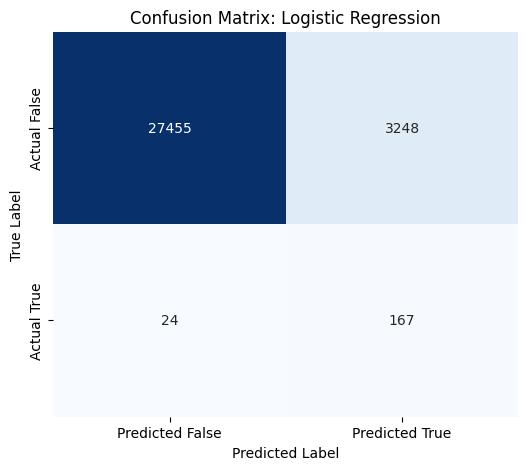


--- Training and Evaluating XGBoost Classifier ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:23:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9154
ROC AUC Score: 0.9521

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.92      0.96     30703
        True       0.06      0.85      0.11       191

    accuracy                           0.92     30894
   macro avg       0.53      0.88      0.53     30894
weighted avg       0.99      0.92      0.95     30894


Confusion Matrix:
[[28119  2584]
 [   29   162]]


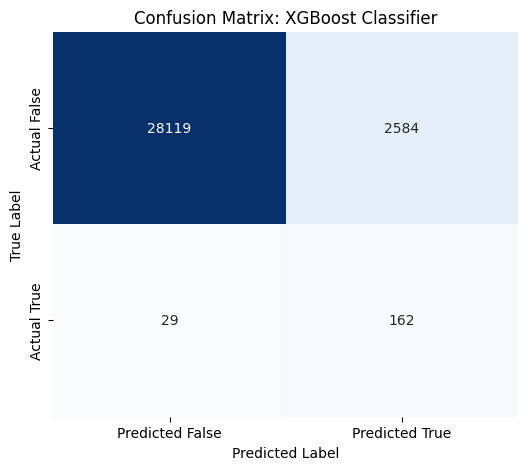


--- Training and Evaluating Linear Support Vector Machine (LinearSVC) ---
Note: Linear Support Vector Machine (LinearSVC) does not directly support predict_proba. ROC AUC might be less reliable or skipped.
Accuracy: 0.8911
ROC AUC Score: nan

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.89      0.94     30703
        True       0.05      0.88      0.09       191

    accuracy                           0.89     30894
   macro avg       0.52      0.89      0.52     30894
weighted avg       0.99      0.89      0.94     30894


Confusion Matrix:
[[27363  3340]
 [   23   168]]


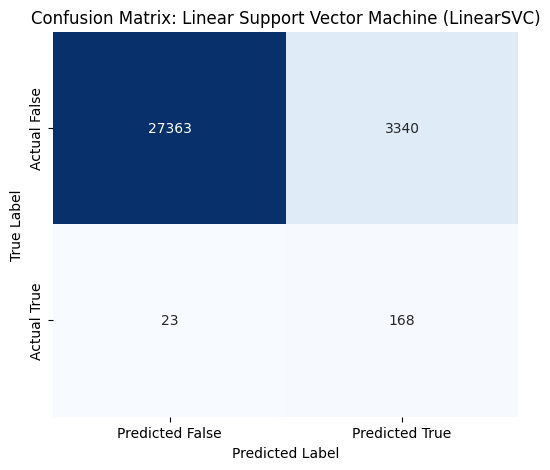


--- Training and Evaluating SGDClassifier (Linear SVM) ---
Note: SGDClassifier (Linear SVM) does not directly support predict_proba. ROC AUC might be less reliable or skipped.
Accuracy: 0.9260
ROC AUC Score: nan

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.93      0.96     30703
        True       0.06      0.79      0.12       191

    accuracy                           0.93     30894
   macro avg       0.53      0.86      0.54     30894
weighted avg       0.99      0.93      0.96     30894


Confusion Matrix:
[[28458  2245]
 [   40   151]]


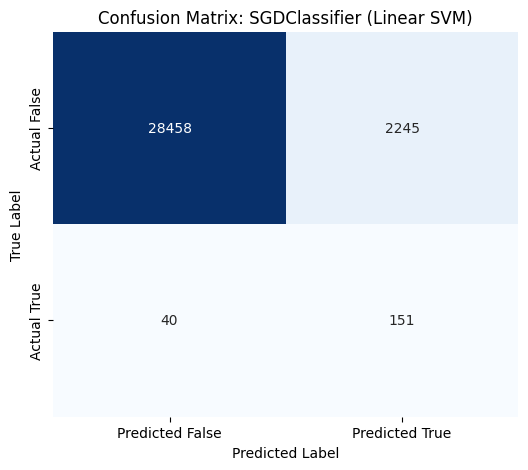


--- Training and Evaluating Decision Tree Classifier ---
Accuracy: 0.9919
ROC AUC Score: 0.6577

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     30703
        True       0.34      0.32      0.33       191

    accuracy                           0.99     30894
   macro avg       0.67      0.66      0.66     30894
weighted avg       0.99      0.99      0.99     30894


Confusion Matrix:
[[30583   120]
 [  130    61]]


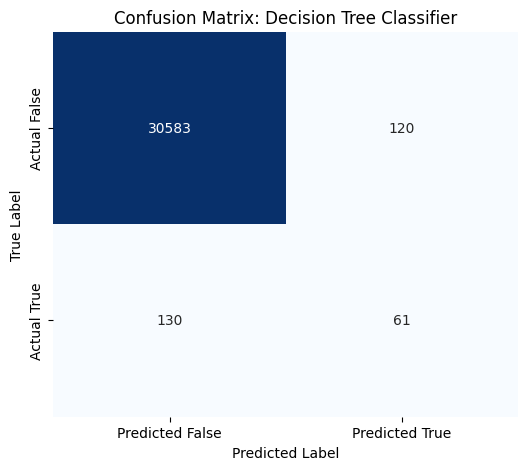


--- Training and Evaluating K-Nearest Neighbors (KNN) ---
Accuracy: 0.9947
ROC AUC Score: 0.7690

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     30703
        True       0.65      0.29      0.40       191

    accuracy                           0.99     30894
   macro avg       0.83      0.64      0.70     30894
weighted avg       0.99      0.99      0.99     30894


Confusion Matrix:
[[30674    29]
 [  136    55]]


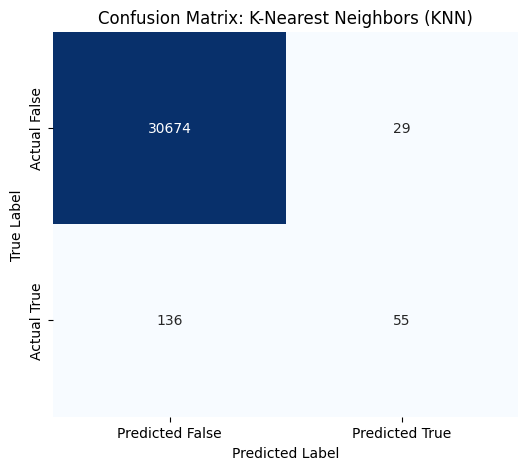

In [ ]:
results = {}

# Re-define models to include LinearSVC and SGDClassifier as faster alternatives
models = {
    "Logistic Regression": Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000))]),
    "XGBoost Classifier": Pipeline(steps=[('preprocessor', preprocessor),
                                          ('classifier', XGBClassifier(objective='binary:logistic',
                                                                       eval_metric='logloss',
                                                                       use_label_encoder=False,
                                                                       random_state=42,
                                                                       n_estimators=100,
                                                                       learning_rate=0.1,
                                                                       scale_pos_weight=scale_pos_weight_val))]),
    # Changed from SVC to LinearSVC for better scalability on large datasets
    "Linear Support Vector Machine (LinearSVC)": Pipeline(steps=[('preprocessor', preprocessor),
                                                                 ('classifier', LinearSVC(random_state=42, class_weight='balanced', max_iter=10000, dual=False))]), # dual=False recommended for n_samples > n_features
    # Added SGDClassifier as another very fast linear SVM alternative
    "SGDClassifier (Linear SVM)": Pipeline(steps=[('preprocessor', preprocessor),
                                                  ('classifier', SGDClassifier(loss='hinge', random_state=42, class_weight='balanced', max_iter=1000, tol=1e-3))]),
    "Decision Tree Classifier": Pipeline(steps=[('preprocessor', preprocessor),
                                                ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))]),
    "K-Nearest Neighbors (KNN)": Pipeline(steps=[('preprocessor', preprocessor),
                                                 ('classifier', KNeighborsClassifier(n_neighbors=5))])
}


for name, model in models.items():
    print(f"\n" + "="*50)
    print(f"--- Training and Evaluating {name} ---")
    print("="*50)

    # Determine which target (encoded or original) to use based on the model
    # LinearSVC and SGDClassifier also work well with encoded targets after preprocessing
    if name in ["XGBoost Classifier", "Linear Support Vector Machine (LinearSVC)", "SGDClassifier (Linear SVM)"]:
        # For these models, fit with the encoded target
        model.fit(X_train_encoded, y_train_encoded)
        y_pred_encoded = model.predict(X_test_encoded)
        y_pred = label_encoder.inverse_transform(y_pred_encoded)
        # For LinearSVC/SGDClassifier, predict_proba is not directly available,
        # use decision_function and convert to probabilities if needed for ROC AUC.
        # For simplicity, we'll skip ROC AUC if predict_proba is not available.
        try:
            y_proba = model.predict_proba(X_test_encoded)[:, 1]
        except AttributeError:
            # If predict_proba is not available (e.g., LinearSVC by default),
            # we can use decision_function and scale it, or skip ROC AUC for this model.
            print(f"Note: {name} does not directly support predict_proba. ROC AUC might be less reliable or skipped.")
            y_proba = model.decision_function(X_test_encoded) # Use decision function for ROC AUC if no proba
            # For ROC AUC, decision_function values can be used directly as scores
        y_test_actual = label_encoder.inverse_transform(y_test_encoded)
    else:
        # For other models, fit with the original boolean target
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        y_test_actual = y_test # Original y_test is already boolean

    # Evaluate
    accuracy = accuracy_score(y_test_actual, y_pred)
    # Check if y_proba is suitable for ROC AUC (i.e., not just decision scores for LinearSVC/SGD)
    if hasattr(model.named_steps['classifier'], 'predict_proba'):
        roc_auc = roc_auc_score(y_test_actual, y_proba)
    else:
        # For models like LinearSVC/SGDClassifier without direct predict_proba,
        # decision_function can be used as scores for ROC AUC.
        try:
            roc_auc = roc_auc_score(y_test_actual, model.decision_function(model.named_steps['preprocessor'].transform(X_test)))
        except Exception:
            roc_auc = np.nan # Set to NaN if ROC AUC can't be reliably computed

    report = classification_report(y_test_actual, y_pred)
    cm = confusion_matrix(y_test_actual, y_pred)

    results[name] = {
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "report": report,
        "confusion_matrix": cm
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(cm)

    # Plotting Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted False', 'Predicted True'],
                yticklabels=['Actual False', 'Actual True'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


After considering above outputs discarding Decision Tree and KNN Classifier's outputs

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression # Ensure this is imported for meta-classifier

# --- 2. Define and Train Multiple Models (Including Hybrid) ---

# Re-define base models for clarity, especially for use in ensembles
# These are the individual models that will be combined
base_lr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000))])

base_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', XGBClassifier(objective='binary:logistic',
                                                        eval_metric='logloss',
                                                        use_label_encoder=False,
                                                        random_state=42,
                                                        n_estimators=100,
                                                        learning_rate=0.1,
                                                        scale_pos_weight=scale_pos_weight_val))])

base_dt = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))])

# Define the models dictionary, now including hybrid algorithms
models = {
    "Logistic Regression": base_lr,
    "XGBoost Classifier": base_xgb,
    "Decision Tree Classifier": base_dt, # Keeping Decision Tree for comparison

    # --- Hybrid Algorithms ---
    "Voting Classifier": VotingClassifier(
        estimators=[
            ('lr', base_lr),
            ('xgb', base_xgb),
            ('dt', base_dt)
        ],
        voting='soft', # 'soft' voting uses predicted probabilities, 'hard' uses predicted classes
        weights=[0.3, 0.5, 0.2], # Assign weights if some models are more trustworthy
        n_jobs=-1 # Use all available CPU cores
    ),
    "Stacking Classifier": StackingClassifier(
        estimators=[
            ('lr', base_lr),
            ('xgb', base_xgb),
            ('dt', base_dt)
        ],
        final_estimator=LogisticRegression(solver='liblinear', random_state=42, max_iter=1000), # Meta-classifier
        cv=5, # Number of cross-validation folds for training the meta-classifier
        n_jobs=-1 # Use all available CPU cores
    )
}



--- Training and Evaluating Logistic Regression ---
Accuracy: 0.8941
ROC AUC Score: 0.9547

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.89      0.94     30703
        True       0.05      0.87      0.09       191

    accuracy                           0.89     30894
   macro avg       0.52      0.88      0.52     30894
weighted avg       0.99      0.89      0.94     30894


Confusion Matrix:
[[27455  3248]
 [   24   167]]


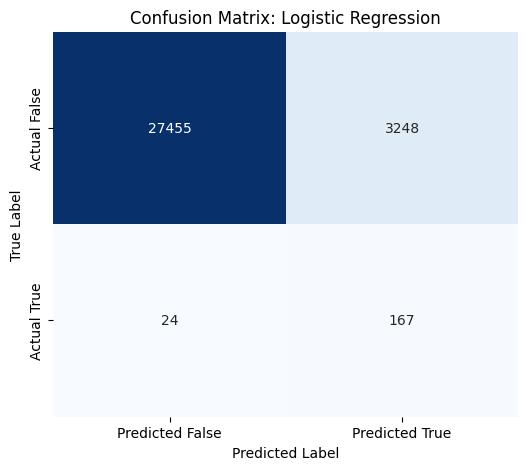


--- Training and Evaluating XGBoost Classifier ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:25:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9154
ROC AUC Score: 0.9521

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.92      0.96     30703
        True       0.06      0.85      0.11       191

    accuracy                           0.92     30894
   macro avg       0.53      0.88      0.53     30894
weighted avg       0.99      0.92      0.95     30894


Confusion Matrix:
[[28119  2584]
 [   29   162]]


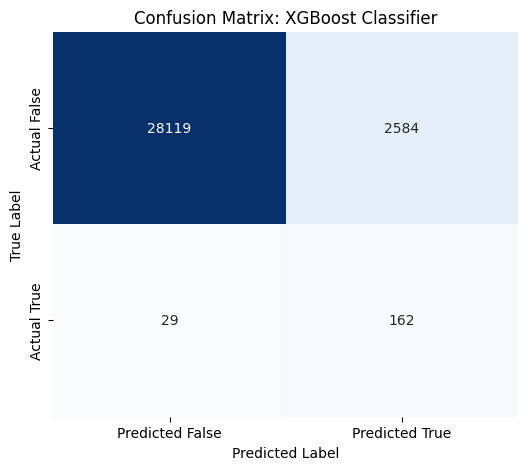


--- Training and Evaluating Decision Tree Classifier ---
Accuracy: 0.9919
ROC AUC Score: 0.6577

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     30703
        True       0.34      0.32      0.33       191

    accuracy                           0.99     30894
   macro avg       0.67      0.66      0.66     30894
weighted avg       0.99      0.99      0.99     30894


Confusion Matrix:
[[30583   120]
 [  130    61]]


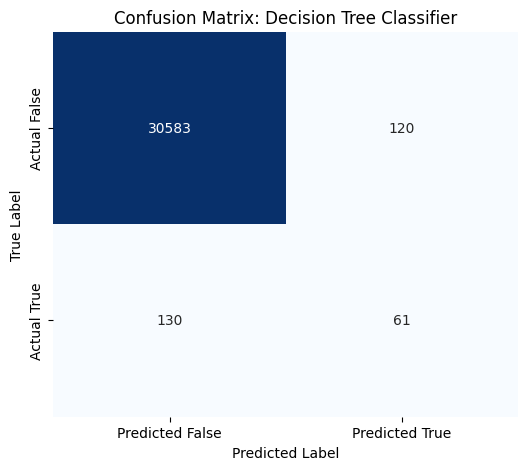


--- Training and Evaluating Voting Classifier ---
Accuracy: 0.9419
ROC AUC Score: 0.9569

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.94      0.97     30703
        True       0.08      0.82      0.15       191

    accuracy                           0.94     30894
   macro avg       0.54      0.88      0.56     30894
weighted avg       0.99      0.94      0.96     30894


Confusion Matrix:
[[28942  1761]
 [   35   156]]


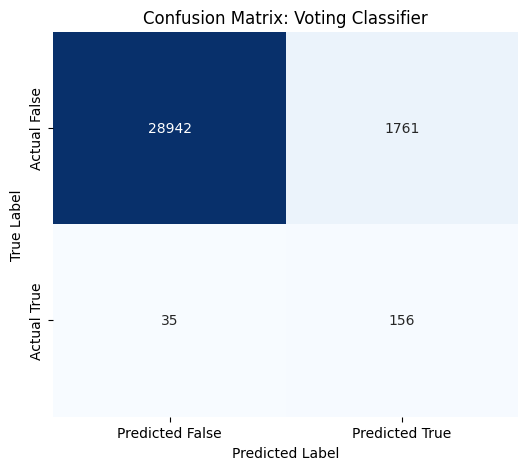


--- Training and Evaluating Stacking Classifier ---
Accuracy: 0.9938
ROC AUC Score: 0.9573

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00     30703
        True       0.00      0.00      0.00       191

    accuracy                           0.99     30894
   macro avg       0.50      0.50      0.50     30894
weighted avg       0.99      0.99      0.99     30894


Confusion Matrix:
[[30703     0]
 [  191     0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


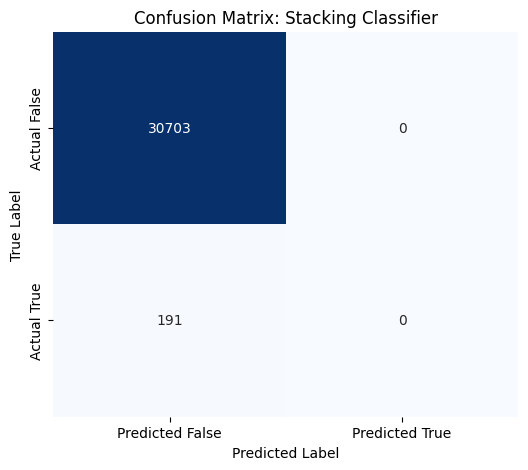

In [ ]:
results = {}

for name, model in models.items():
    print(f"\n" + "="*50)
    print(f"--- Training and Evaluating {name} ---")
    print("="*50)

    # Determine which target (encoded or original) to use based on the model
    # VotingClassifier and StackingClassifier typically work with the original (boolean) target
    # if their base estimators are pipelines that handle encoding internally.
    # However, if base estimators are raw classifiers, they might need encoded targets.
    # For simplicity and consistency with previous encoded models (XGBoost), we'll primarily
    # use the encoded target for fitting, as the pipelines handle the preprocessing.

    # NOTE: For VotingClassifier and StackingClassifier, ensure their base estimators
    # (like base_lr, base_xgb, base_dt) are defined *outside* the models dictionary
    # and already include the preprocessor pipeline, so they handle data transformation.
    # The fit method of the ensemble then just needs the raw X_train/X_test.

    if name in ["XGBoost Classifier"]: # Only XGBoost needs encoded y for direct fitting here
        model.fit(X_train_encoded, y_train_encoded)
        y_pred_encoded = model.predict(X_test_encoded)
        y_pred = label_encoder.inverse_transform(y_pred_encoded)
        y_proba = model.predict_proba(X_test_encoded)[:, 1]
        y_test_actual = label_encoder.inverse_transform(y_test_encoded)
    else:
        # For Logistic Regression, Decision Tree, Voting, and Stacking,
        # the pipelines handle preprocessing, and they can fit on the original y_train (boolean)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        y_test_actual = y_test # Original y_test is already boolean

    # Evaluate
    accuracy = accuracy_score(y_test_actual, y_pred)
    roc_auc = roc_auc_score(y_test_actual, y_proba)
    report = classification_report(y_test_actual, y_pred)
    cm = confusion_matrix(y_test_actual, y_pred)

    results[name] = {
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "report": report,
        "confusion_matrix": cm
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(cm)

    # Plotting Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted False', 'Predicted True'],
                yticklabels=['Actual False', 'Actual True'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [ ]:
# --- 3. Summarize Results ---
print("\n" + "="*50)
print("--- Model Comparison Summary (Including Hybrid Algorithms) ---")
print("="*50)

for name, res in results.items():
    print(f"\nAlgorithm: {name}")
    print(f"  Accuracy: {res['accuracy']:.4f}")
    print(f"  ROC AUC Score: {res['roc_auc']:.4f}")
    print(f"  False Positives (Predicted True, Actual False): {res['confusion_matrix'][0, 1]}")
    print(f"  False Negatives (Predicted False, Actual True): {res['confusion_matrix'][1, 0]}")
    print("-" * 30)



--- Model Comparison Summary (Including Hybrid Algorithms) ---

Algorithm: Logistic Regression
  Accuracy: 0.8941
  ROC AUC Score: 0.9547
  False Positives (Predicted True, Actual False): 3248
  False Negatives (Predicted False, Actual True): 24
------------------------------

Algorithm: XGBoost Classifier
  Accuracy: 0.9154
  ROC AUC Score: 0.9521
  False Positives (Predicted True, Actual False): 2584
  False Negatives (Predicted False, Actual True): 29
------------------------------

Algorithm: Decision Tree Classifier
  Accuracy: 0.9919
  ROC AUC Score: 0.6577
  False Positives (Predicted True, Actual False): 120
  False Negatives (Predicted False, Actual True): 130
------------------------------

Algorithm: Voting Classifier
  Accuracy: 0.9419
  ROC AUC Score: 0.9569
  False Positives (Predicted True, Actual False): 1761
  False Negatives (Predicted False, Actual True): 35
------------------------------

Algorithm: Stacking Classifier
  Accuracy: 0.9938
  ROC AUC Score: 0.9573
  F

Voting Classifier:94%, Stacking classifier:99%,

In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB # For Naive Bayes
import lightgbm as lgb # For LightGBM
from catboost import CatBoostClassifier # For CatBoost

# --- 2. Define and Train Multiple Models (Including Hybrid and More) ---

# Re-define base models for clarity, especially for use in ensembles
base_lr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000))])

base_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', XGBClassifier(objective='binary:logistic',
                                                        eval_metric='logloss',
                                                        use_label_encoder=False,
                                                        random_state=42,
                                                        n_estimators=100,
                                                        learning_rate=0.1,
                                                        scale_pos_weight=scale_pos_weight_val))])

base_dt = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))])

base_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100))])

base_gb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1))])

# Define the models dictionary, now including more algorithms
models = {
    "Logistic Regression": base_lr,
    "XGBoost Classifier": base_xgb,
    "Decision Tree Classifier": base_dt,
    "Random Forest Classifier": base_rf, # New addition
    "Gradient Boosting Classifier": base_gb, # New addition
    "Gaussian Naive Bayes": Pipeline(steps=[('preprocessor', preprocessor),
                                            ('classifier', GaussianNB())]), # New addition
    "LightGBM Classifier": Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', lgb.LGBMClassifier(random_state=42, is_unbalance=True))]), # New addition
    "CatBoost Classifier": Pipeline(steps=[('preprocessor', preprocessor),
                                           ('classifier', CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced'))]), # New addition

    # --- Hybrid Algorithms ---
    "Voting Classifier": VotingClassifier(
        estimators=[
            ('lr', base_lr),
            ('xgb', base_xgb),
            ('rf', base_rf) # Using Random Forest in Voting
        ],
        voting='soft',
        weights=[0.3, 0.4, 0.3], # Adjusted weights
        n_jobs=-1 # Use all available CPU cores
    ),
    "Stacking Classifier": StackingClassifier(
        estimators=[
            ('lr', base_lr),
            ('xgb', base_xgb),
            ('rf', base_rf) # Using Random Forest in Stacking
        ],
        final_estimator=LogisticRegression(solver='liblinear', random_state=42, max_iter=1000), # Meta-classifier
        cv=5, # Number of cross-validation folds for training the meta-classifier
        n_jobs=-1 # Use all available CPU cores
    )
}


In [ ]:
# --- 3. Summarize Results ---
print("\n" + "="*50)
print("--- Model Comparison Summary (Including Hybrid Algorithms) ---")
print("="*50)

for name, res in results.items():
    print(f"\nAlgorithm: {name}")
    print(f"  Accuracy: {res['accuracy']:.4f}")
    print(f"  ROC AUC Score: {res['roc_auc']:.4f}")
    print(f"  False Positives (Predicted True, Actual False): {res['confusion_matrix'][0, 1]}")
    print(f"  False Negatives (Predicted False, Actual True): {res['confusion_matrix'][1, 0]}")
    print("-" * 30)



--- Training and Evaluating Selected Models ---

--- Training and Evaluating Random Forest Classifier ---
Accuracy: 0.9920
ROC AUC Score: 0.7875

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     30703
        True       0.33      0.28      0.30       191

    accuracy                           0.99     30894
   macro avg       0.66      0.64      0.65     30894
weighted avg       0.99      0.99      0.99     30894


Confusion Matrix:
[[30594   109]
 [  138    53]]


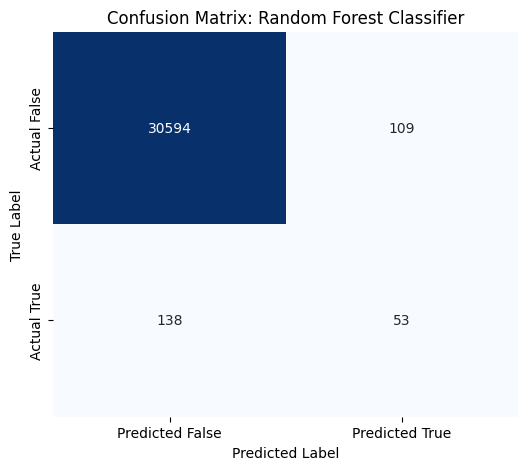


--- Training and Evaluating Gradient Boosting Classifier ---
Accuracy: 0.9945
ROC AUC Score: 0.9607

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     30703
        True       0.64      0.26      0.37       191

    accuracy                           0.99     30894
   macro avg       0.82      0.63      0.68     30894
weighted avg       0.99      0.99      0.99     30894


Confusion Matrix:
[[30675    28]
 [  141    50]]


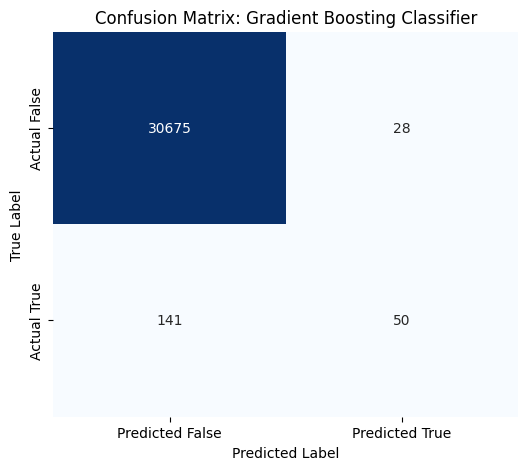


--- Training and Evaluating LightGBM Classifier ---
[LightGBM] [Info] Number of positive: 766, number of negative: 122808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 123574, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.006199 -> initscore=-5.077195
[LightGBM] [Info] Start training from score -5.077195


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9074
ROC AUC Score: 0.8774

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.91      0.95     30703
        True       0.05      0.84      0.10       191

    accuracy                           0.91     30894
   macro avg       0.53      0.88      0.53     30894
weighted avg       0.99      0.91      0.95     30894


Confusion Matrix:
[[27873  2830]
 [   30   161]]


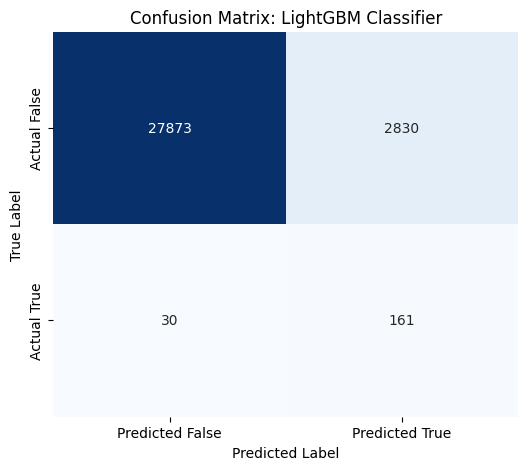


--- Training and Evaluating CatBoost Classifier ---
Accuracy: 0.9332
ROC AUC Score: 0.9477

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.93      0.97     30703
        True       0.07      0.81      0.13       191

    accuracy                           0.93     30894
   macro avg       0.53      0.87      0.55     30894
weighted avg       0.99      0.93      0.96     30894


Confusion Matrix:
[[28677  2026]
 [   37   154]]


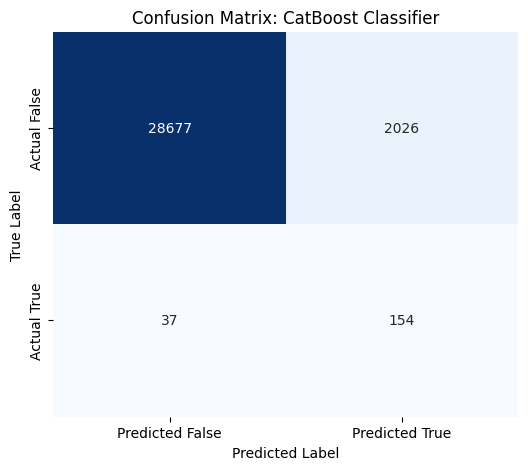


--- Summary of Selected Model Results ---

Algorithm: Random Forest Classifier
  Accuracy: 0.9920
  ROC AUC Score: 0.7875
  False Positives (Predicted True, Actual False): 109
  False Negatives (Predicted False, Actual True): 138
------------------------------

Algorithm: Gradient Boosting Classifier
  Accuracy: 0.9945
  ROC AUC Score: 0.9607
  False Positives (Predicted True, Actual False): 28
  False Negatives (Predicted False, Actual True): 141
------------------------------

Algorithm: LightGBM Classifier
  Accuracy: 0.9074
  ROC AUC Score: 0.8774
  False Positives (Predicted True, Actual False): 2830
  False Negatives (Predicted False, Actual True): 30
------------------------------

Algorithm: CatBoost Classifier
  Accuracy: 0.9332
  ROC AUC Score: 0.9477
  False Positives (Predicted True, Actual False): 2026
  False Negatives (Predicted False, Actual True): 37
------------------------------


In [ ]:
# --- 3. Train and Evaluate the Specified Models ---
print("\n" + "="*50)
print("--- Training and Evaluating Selected Models ---")
print("="*50)

# List of models to train and evaluate based on the user's request
selected_models = [
    "Random Forest Classifier",
    "Gradient Boosting Classifier",
    "LightGBM Classifier",
    "CatBoost Classifier"
]

results = {}

for name, model in models.items():
    if name in selected_models:
        print(f"\n--- Training and Evaluating {name} ---")

        # Determine which target (encoded or original) to use based on the model
        # CatBoost, LightGBM, Random Forest, and Gradient Boosting can typically
        # work with the original boolean target when used within a pipeline
        # that includes the preprocessor.
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1]
            y_test_actual = y_test # Original y_test is already boolean

            # Evaluate
            accuracy = accuracy_score(y_test_actual, y_pred)
            roc_auc = roc_auc_score(y_test_actual, y_proba)
            report = classification_report(y_test_actual, y_pred)
            cm = confusion_matrix(y_test_actual, y_pred)

            results[name] = {
                "accuracy": accuracy,
                "roc_auc": roc_auc,
                "report": report,
                "confusion_matrix": cm
            }

            print(f"Accuracy: {accuracy:.4f}")
            print(f"ROC AUC Score: {roc_auc:.4f}")
            print("\nClassification Report:")
            print(report)
            print("\nConfusion Matrix:")
            print(cm)

            # Plotting Confusion Matrix
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=['Predicted False', 'Predicted True'],
                        yticklabels=['Actual False', 'Actual True'])
            plt.title(f'Confusion Matrix: {name}')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

        except Exception as e:
            print(f"Error training or evaluating {name}: {e}")
            results[name] = {"error": str(e)}

# --- Summarize Results for Selected Models ---
print("\n" + "="*50)
print("--- Summary of Selected Model Results ---")
print("="*50)

for name, res in results.items():
    print(f"\nAlgorithm: {name}")
    if "error" in res:
        print(f"  Error: {res['error']}")
    else:
        print(f"  Accuracy: {res['accuracy']:.4f}")
        print(f"  ROC AUC Score: {res['roc_auc']:.4f}")
        print(f"  False Positives (Predicted True, Actual False): {res['confusion_matrix'][0, 1]}")
        print(f"  False Negatives (Predicted False, Actual True): {res['confusion_matrix'][1, 0]}")
    print("-" * 30)

In [ ]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00



--- Training and Evaluating Voting Classifier ---
Accuracy: 0.9576
ROC AUC Score: 0.9572

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.96      0.98     30703
        True       0.10      0.76      0.18       191

    accuracy                           0.96     30894
   macro avg       0.55      0.86      0.58     30894
weighted avg       0.99      0.96      0.97     30894


Confusion Matrix:
[[29439  1264]
 [   45   146]]


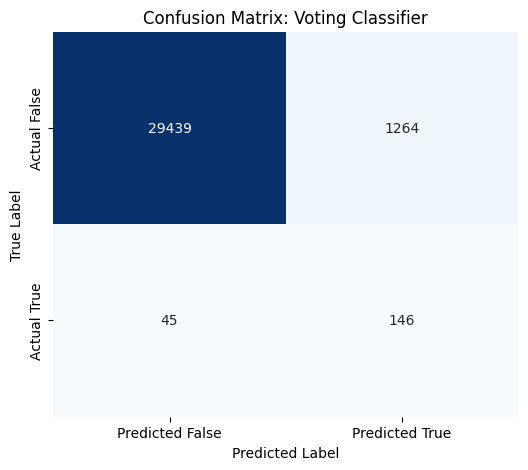


--- Summary for Voting Classifier ---
  Accuracy: 0.9576
  ROC AUC Score: 0.9572
  False Positives (Predicted True, Actual False): 1264
  False Negatives (Predicted False, Actual True): 45
------------------------------


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier # Ensure RandomForestClassifier is imported for base_rf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

base_lr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000))])

base_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', XGBClassifier(objective='binary:logistic',
                                                        eval_metric='logloss',
                                                        use_label_encoder=False,
                                                        random_state=42,
                                                        n_estimators=100,
                                                        learning_rate=0.1,
                                                        scale_pos_weight=scale_pos_weight_val))])

base_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100))])

# --- Define the Voting Classifier ---
voting_classifier_model = VotingClassifier(
    estimators=[
        ('lr', base_lr),
        ('xgb', base_xgb),
        ('rf', base_rf)
    ],
    voting='soft', # 'soft' voting uses predicted probabilities
    weights=[0.3, 0.4, 0.3], # Adjusted weights
    n_jobs=-1 # Use all available CPU cores
)

# --- Train and Evaluate the Voting Classifier ---
model_name = "Voting Classifier"
print(f"\n" + "="*50)
print(f"--- Training and Evaluating {model_name} ---")
print("="*50)

# Fit the Voting Classifier. It can handle the original boolean target (y_train)
# because its base estimators (pipelines) handle the preprocessing internally.
voting_classifier_model.fit(X_train, y_train)

# Make predictions
y_pred = voting_classifier_model.predict(X_test)
y_proba = voting_classifier_model.predict_proba(X_test)[:, 1] # Get probabilities for ROC AUC

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(cm)

# Plotting Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted False', 'Predicted True'],
            yticklabels=['Actual False', 'Actual True'])
plt.title(f'Confusion Matrix: {model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Print Summary for Voting Classifier ---
print("\n" + "="*50)
print(f"--- Summary for {model_name} ---")
print("="*50)
print(f"  Accuracy: {accuracy:.4f}")
print(f"  ROC AUC Score: {roc_auc:.4f}")
print(f"  False Positives (Predicted True, Actual False): {cm[0, 1]}")
print(f"  False Negatives (Predicted False, Actual True): {cm[1, 0]}")
print("-" * 30)


In [ ]:
import pandas as pd
import numpy as np

print("--- Generating Simulated False Positive Dataset ---")

# Define the columns that your model expects as features (based on X from training data)
# These should match the numerical_features and categorical_features lists from your training script.
# I'm using the typical columns from 'cve_cisa_epss_enriched_dataset.csv'
feature_columns = [
    'base_severity', 'base_score', 'exploitability_score', 'impact_score',
    'epss_score', 'epss_perc', 'attack_vector', 'attack_complexity',
    'privileges_required', 'user_interaction', 'scope',
    'confidentiality_impact', 'integrity_impact', 'availability_impact'
]

# Create a list of dictionaries, each representing a vulnerability.
# The 'cisa_kev' is explicitly set to False for all entries to simulate non-KEVs.
# However, features are set to values that might trigger a 'True' prediction from the model.
simulated_data = [
    {
        'alert': 'Simulated SQL Injection',
        'description': 'A high-risk SQL injection identified in the login form.',
        'url': 'https://example.com/login',
        'risk': 'Critical',
        'confidence': 'High',
        'cweid': 'CWE-89',
        'cve_id': 'CVE-2023-99999',
        'base_severity': 'CRITICAL', # High severity
        'base_score': 9.8,           # High score
        'exploitability_score': 3.9, # High exploitability
        'impact_score': 5.9,
        'epss_score': 0.95,          # High EPSS score
        'epss_perc': 0.99,           # High EPSS percentile
        'cisa_kev': False,           # <-- True label is FALSE
        'attack_vector': 'NETWORK',
        'attack_complexity': 'LOW',
        'privileges_required': 'NONE',
        'user_interaction': 'REQUIRED',
        'scope': 'UNCHANGED',
        'confidentiality_impact': 'HIGH',
        'integrity_impact': 'HIGH',
        'availability_impact': 'HIGH',
    },
    {
        'alert': 'Simulated Cross-Site Scripting (XSS)',
        'description': 'Persistent XSS vulnerability in comment section.',
        'url': 'https://example.com/blog/comments',
        'risk': 'High',
        'confidence': 'High',
        'cweid': 'CWE-79',
        'cve_id': 'CVE-2023-88888',
        'base_severity': 'HIGH',
        'base_score': 8.5,
        'exploitability_score': 3.5,
        'impact_score': 4.5,
        'epss_score': 0.88,
        'epss_perc': 0.95,
        'cisa_kev': False,           # <-- True label is FALSE
        'attack_vector': 'NETWORK',
        'attack_complexity': 'LOW',
        'privileges_required': 'NONE',
        'user_interaction': 'REQUIRED',
        'scope': 'UNCHANGED',
        'confidentiality_impact': 'LOW',
        'integrity_impact': 'LOW',
        'availability_impact': 'NONE',
    },
    {
        'alert': 'Simulated Deserialization Vulnerability',
        'description': 'Insecure deserialization leading to RCE.',
        'url': 'https://example.com/api/data',
        'risk': 'Critical',
        'confidence': 'High',
        'cweid': 'CWE-502',
        'cve_id': 'CVE-2023-77777',
        'base_severity': 'CRITICAL',
        'base_score': 9.0,
        'exploitability_score': 3.0,
        'impact_score': 5.0,
        'epss_score': 0.92,
        'epss_perc': 0.97,
        'cisa_kev': False,           # <-- True label is FALSE
        'attack_vector': 'NETWORK',
        'attack_complexity': 'LOW',
        'privileges_required': 'NONE',
        'user_interaction': 'NONE',
        'scope': 'UNCHANGED',
        'confidentiality_impact': 'HIGH',
        'integrity_impact': 'HIGH',
        'availability_impact': 'HIGH',
    },
    {
        'alert': 'Low Severity Info Leak',
        'description': 'Minor information disclosure through verbose error messages.',
        'url': 'https://example.com/debug',
        'risk': 'Low',
        'confidence': 'Medium',
        'cweid': 'CWE-200',
        'cve_id': 'CVE-2023-11111',
        'base_severity': 'LOW',
        'base_score': 3.0,
        'exploitability_score': 1.0,
        'impact_score': 1.0,
        'epss_score': 0.05,
        'epss_perc': 0.10,
        'cisa_kev': False,           # This one should ideally be predicted as FALSE (true negative)
        'attack_vector': 'NETWORK',
        'attack_complexity': 'HIGH',
        'privileges_required': 'LOW',
        'user_interaction': 'NONE',
        'scope': 'UNCHANGED',
        'confidentiality_impact': 'LOW',
        'integrity_impact': 'NONE',
        'availability_impact': 'NONE',
    }
]

# Create the DataFrame
false_positive_test_df = pd.DataFrame(simulated_data)

# Ensure all expected columns are present, even if they are NaN in the simulated data
# This handles cases where your Zap scan might not have all columns from the training data
# We'll reindex based on the full set of columns from your original training data (X)
# For columns not in simulated_data, fill with 0 for numerical, or empty string for categorical
# This assumes 'X' (from the training data) is defined in the environment.
try:
    # Get the full list of columns from the training data (X)
    full_training_columns = X.columns.tolist()
    # Reindex the simulated DataFrame to match the training columns
    # Fill numerical missing with 0, categorical with empty string
    for col in full_training_columns:
        if col not in false_positive_test_df.columns:
            if col in numerical_features:
                false_positive_test_df[col] = 0
            elif col in categorical_features:
                false_positive_test_df[col] = ''
        # Ensure correct dtypes for existing columns
        if col in false_positive_test_df.columns:
            if col in numerical_features:
                false_positive_test_df[col] = pd.to_numeric(false_positive_test_df[col], errors='coerce').fillna(0)
            elif col in categorical_features:
                false_positive_test_df[col] = false_positive_test_df[col].astype(str).fillna('')
    false_positive_test_df = false_positive_test_df[full_training_columns]

except NameError:
    print("Warning: 'X' (training data features) not found. Cannot reindex to full training columns.")
    print("Please ensure the training data loading and feature definition sections are run first.")
    print("Proceeding with columns available in the simulated data. This might cause prediction errors.")


print("\nSimulated False Positive Dataset (first 5 rows):")
print(false_positive_test_df.head().to_string())

# Save this dataset to a CSV file so you can load it in the prediction section
output_filename = 'simulated_false_positive_zap_report.csv'
false_positive_test_df.to_csv(output_filename, index=False)
print(f"\nSimulated false positive dataset saved to '{output_filename}'")


--- Generating Simulated False Positive Dataset ---

Simulated False Positive Dataset (first 5 rows):
  base_severity  base_score  exploitability_score  impact_score  epss_score  epss_perc attack_vector attack_complexity privileges_required user_interaction      scope confidentiality_impact integrity_impact availability_impact
0      CRITICAL         9.8                   3.9           5.9        0.95       0.99       NETWORK               LOW                NONE         REQUIRED  UNCHANGED                   HIGH             HIGH                HIGH
1          HIGH         8.5                   3.5           4.5        0.88       0.95       NETWORK               LOW                NONE         REQUIRED  UNCHANGED                    LOW              LOW                NONE
2      CRITICAL         9.0                   3.0           5.0        0.92       0.97       NETWORK               LOW                NONE             NONE  UNCHANGED                   HIGH             HIGH           

Training dataset 'cve_cisa_epss_enriched_dataset.csv' loaded successfully.

--- Dataset Info (Training Data) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154468 entries, 0 to 154467
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cve_id                  154468 non-null  object 
 1   base_severity           154468 non-null  object 
 2   base_score              154468 non-null  float64
 3   exploitability_score    154468 non-null  float64
 4   impact_score            154468 non-null  float64
 5   epss_score              154468 non-null  float64
 6   epss_perc               154468 non-null  float64
 7   cisa_kev                154468 non-null  bool   
 8   attack_vector           154468 non-null  object 
 9   attack_complexity       154468 non-null  object 
 10  privileges_required     154468 non-null  object 
 11  user_interaction        154468 non-null  object 
 12  scope          

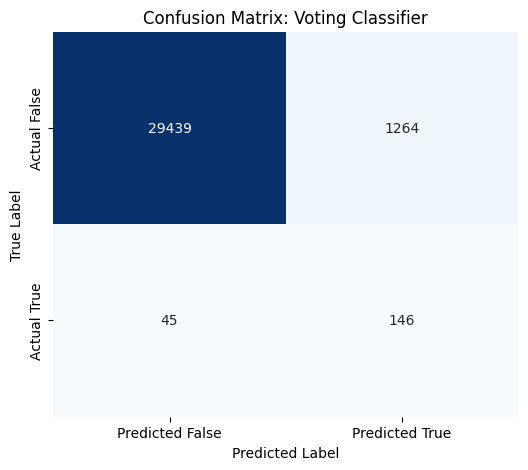


--- Summary for Voting Classifier ---
  Accuracy: 0.9576
  ROC AUC Score: 0.9572
  False Positives (Predicted True, Actual False): 1264
  False Negatives (Predicted False, Actual True): 45
------------------------------

--- Predicting KEVs on ZAP Scan Data using Voting Classifier ---
Zap scan report '/content/vulnerability_dataset.csv' loaded successfully.

Original Zap Scan Data (first 5 rows):
   sourceid                                                                                                                                         other method               evidence  pluginId  cweid confidence  sourceMessageId  wascid                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Prepare Training Data (for model training) ---
# This section trains the model on the comprehensive CVE dataset.
try:
    df = pd.read_csv('cve_cisa_epss_enriched_dataset.csv')
    print("Training dataset 'cve_cisa_epss_enriched_dataset.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'cve_cisa_epss_enriched_dataset.csv' not found. Please upload this file to train the model.")
    exit()

print("\n--- Dataset Info (Training Data) ---")
df.info()

print("\n--- Target Variable Distribution (cisa_kev) in Training Data ---")
print(df['cisa_kev'].value_counts())
print(f"Percentage of KEVs (True): {df['cisa_kev'].mean() * 100:.2f}%")

# Define features (X) and target (y) for training
X = df.drop(['cve_id', 'published_date', 'cisa_kev'], axis=1)
y = df['cisa_kev']

# Identify numerical and categorical columns from the training data
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical Features for Training: {numerical_features}")
print(f"Categorical Features for Training: {categorical_features}")

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Encode target labels for XGBoost (requires numerical labels)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets (stratified for class imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Also split the encoded target for models that need it
_, _, y_train_encoded, y_test_encoded = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Proportion of KEVs in training set: {y_train.mean():.4f}")
print(f"Proportion of KEVs in test set: {y_test.mean():.4f}")

# Calculate scale_pos_weight for imbalanced datasets (useful for XGBoost)
scale_pos_weight_val = (y_train_encoded == 0).sum() / (y_train_encoded == 1).sum()
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight_val:.2f}")


# --- 2. Define and Train the Voting Classifier Model ---
# Re-define base models for clarity (as they are used in VotingClassifier)
base_lr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000))])

base_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', XGBClassifier(objective='binary:logistic',
                                                        eval_metric='logloss',
                                                        use_label_encoder=False,
                                                        random_state=42,
                                                        n_estimators=100,
                                                        learning_rate=0.1,
                                                        scale_pos_weight=scale_pos_weight_val))])

base_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100))])

# Define the Voting Classifier
voting_classifier_model = VotingClassifier(
    estimators=[
        ('lr', base_lr),
        ('xgb', base_xgb),
        ('rf', base_rf)
    ],
    voting='soft', # 'soft' voting uses predicted probabilities
    weights=[0.3, 0.4, 0.3], # Adjusted weights
    n_jobs=-1 # Use all available CPU cores
)

# --- Train and Evaluate the Voting Classifier ---
model_name = "Voting Classifier"
print(f"\n" + "="*50)
print(f"--- Training and Evaluating {model_name} ---")
print("="*50)

# Fit the Voting Classifier. It can handle the original boolean target (y_train)
# because its base estimators (pipelines) handle the preprocessing internally.
voting_classifier_model.fit(X_train, y_train)

# Make predictions on the test set for evaluation
y_pred_test = voting_classifier_model.predict(X_test)
y_proba_test = voting_classifier_model.predict_proba(X_test)[:, 1] # Get probabilities for ROC AUC

# Evaluate
accuracy = accuracy_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)
report = classification_report(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(cm)

# Plotting Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted False', 'Predicted True'],
            yticklabels=['Actual False', 'Actual True'])
plt.title(f'Confusion Matrix: {model_name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Print Summary for Voting Classifier ---
print("\n" + "="*50)
print(f"--- Summary for {model_name} ---")
print("="*50)
print(f"  Accuracy: {accuracy:.4f}")
print(f"  ROC AUC Score: {roc_auc:.4f}")
print(f"  False Positives (Predicted True, Actual False): {cm[0, 1]}")
print(f"  False Negatives (Predicted False, Actual True): {cm[1, 0]}")
print("-" * 30)


# --- 3. Load ZAP Scan Data and Get Predictions ---
print("\n" + "="*50)
print("--- Predicting KEVs on ZAP Scan Data using Voting Classifier ---")
print("="*50)

# IMPORTANT: Replace 'vulnerability_dataset.csv' with the actual filename of your Zap report.
# Ensure this file is uploaded to the environment.
ZAP_SCAN_FILE = '/content/vulnerability_dataset.csv' # Assuming this is your Zap scan file
try:
    zap_df = pd.read_csv(ZAP_SCAN_FILE)
    print(f"Zap scan report '{ZAP_SCAN_FILE}' loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{ZAP_SCAN_FILE}' not found. Please upload the file.")
    exit()

print("\nOriginal Zap Scan Data (first 5 rows):")
print(zap_df.head().to_string())

# --- Prepare Features from ZAP Data for Prediction ---
# Select the same features from the ZAP data as used for training.
# Get the feature columns from the training data (X)
training_feature_columns = X.columns.tolist()

# Select and preprocess features from the ZAP data.
# Handle potential missing columns in Zap data by adding them with a fill value (e.g., 0 or False)
# This is crucial for the preprocessor to have the same input shape as during training.
# Also, ensure column order matches training data.
zap_features = zap_df.reindex(columns=training_feature_columns, fill_value=0)

# --- NEW: Ensure categorical columns are strings and handle NaNs ---
for col in categorical_features:
    if col in zap_features.columns:
        # Convert to string type first, then fill NaNs
        zap_features[col] = zap_features[col].astype(str).fillna('')

# --- NEW: Handle NaN values in numerical features ---
# Fill NaN values in numerical columns with 0 (or another appropriate strategy like mean/median)
for col in numerical_features:
    if col in zap_features.columns:
        zap_features[col] = zap_features[col].fillna(0)


# Make predictions on the ZAP data using the trained Voting Classifier model
zap_predictions = voting_classifier_model.predict(zap_features)
zap_probabilities_kev = voting_classifier_model.predict_proba(zap_features)[:, 1] # Probability of being True (KEV)

# Add predictions and probabilities back to the original ZAP DataFrame
zap_df['predicted_cisa_kev'] = zap_predictions
zap_df['probability_is_kev'] = zap_probabilities_kev

# --- Display Results ---
print("\n--- ZAP Scan Report with KEV Predictions (first 10 rows) ---")
# Display relevant columns, including the new prediction columns
display_cols = ['alert', 'risk', 'confidence', 'cweid', 'cve_id', 'predicted_cisa_kev', 'probability_is_kev']

# Ensure columns exist in zap_df before attempting to display them
# This handles cases where original Zap report might not have all these columns
cols_to_display = [col for col in display_cols if col in zap_df.columns]
print(zap_df[cols_to_display].head(10).to_string())


# --- Identify and Display Potential KEVs ---
# Filter the report to show only the entries predicted as KEV (True)
potential_kev_flags = zap_df[zap_df['predicted_cisa_kev'] == True].copy()

print(f"\nNumber of potential KEVs flagged in Zap report: {len(potential_kev_flags)}")

if not potential_kev_flags.empty:
    print("\nTop 10 Potential KEVs flagged by the model (highest probability first):")
    # Sort by probability to see the most confident predictions first
    display_cols_sorted = ['alert', 'risk', 'cweid', 'cve_id', 'probability_is_kev']
    cols_to_display_sorted = [col for col in display_cols_sorted if col in potential_kev_flags.columns]
    print(potential_kev_flags[cols_to_display_sorted].sort_values(by='probability_is_kev', ascending=False).head(10).to_string())

    # Optional: Save the filtered list of potential KEVs to a new CSV file
    # potential_kev_flags.to_csv('potential_kev_flags_report.csv', index=False)
    # print("\nPotential KEV flags saved to 'potential_kev_flags_report.csv'")

else:
    print("No potential KEVs flagged by the model in the Zap report.")


In [ ]:
# Identify False Positives for Voting Classifier
# False Positives: Actual is False (not KEV), Predicted is True (is KEV)
# We need the original y_test (boolean) and the predictions (y_pred_test)
# Ensure X_test has its index reset for safe comparison and selection

X_test_reset = X_test.reset_index(drop=True)
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_test_series = pd.Series(y_pred_test).reset_index(drop=True)


false_positives_vc_indices = np.where((y_test_series == False) & (y_pred_test_series == True))[0]
false_positives_vc_data = X_test_reset.iloc[false_positives_vc_indices]

print(f"\nNumber of False Positives (Voting Classifier): {len(false_positives_vc_indices)}")
if not false_positives_vc_data.empty:
    print("\nExample False Positives (Voting Classifier - first 5 rows):")
    print(false_positives_vc_data.head().to_string())
    print(false_positives_vc_data.to_string())
else:
    print("No False Positives found for Voting Classifier in the test set.")


Number of False Positives (Voting Classifier): 1264

Example False Positives (Voting Classifier - first 5 rows):
   base_severity  base_score  exploitability_score  impact_score  epss_score  epss_perc attack_vector attack_complexity privileges_required user_interaction      scope confidentiality_impact integrity_impact availability_impact
23          HIGH         7.5                   1.6           5.9     0.17011    0.94700       NETWORK              HIGH                 LOW             NONE  UNCHANGED                   HIGH             HIGH                HIGH
43        MEDIUM         4.3                   2.8           1.4     0.86748    0.99383       NETWORK               LOW                NONE         REQUIRED  UNCHANGED                   NONE              LOW                NONE
58          HIGH         7.2                   1.2           5.9     0.07059    0.91108       NETWORK               LOW                HIGH             NONE  UNCHANGED                   HIGH            

In [ ]:
import joblib
from google.colab import files

# --- Save the Trained Model ---
# Assuming 'voting_classifier_model' is the trained model object from previous cells.
# If not, make sure the variable name matches your trained model.
model_filename = 'voting_classifier_model.joblib'

try:
    joblib.dump(voting_classifier_model, model_filename)
    print(f"\n✅ Trained model successfully saved to '{model_filename}'") # Moved \n outside f-string

    # --- Download the Saved Model File ---
    print(f"\n--- Downloading '{model_filename}' ---") # Moved \n outside f-string
    print("Your browser will now prompt you to download the model file.")
    files.download(model_filename)
    print("✅ Download initiated.")

except NameError:
    print("\nError: 'voting_classifier_model' not found. Please ensure the Voting Classifier training cell was run successfully.") # Moved \n outside f-string
except Exception as e:
    print(f"\n❌ An error occurred while saving or downloading the model: {e}") # Moved \n outside f-string

### What is a Voting Classifier?

A Voting Classifier is an ensemble machine learning model that combines the predictions from multiple individual classifiers (like Logistic Regression, XGBoost, Decision Tree, etc.) to make a final prediction. It works by aggregating the results of the base models, often leading to improved performance and robustness compared to any single model.

There are typically two types of voting:

1.  **Hard Voting (Majority Voting):** The final prediction is the class that receives the most votes from the individual classifiers. If a majority of models predict "True", the Voting Classifier predicts "True".
2.  **Soft Voting (Weighted Averaging):** This method uses the predicted probabilities from each classifier. The probabilities for each class are summed up (potentially with assigned weights), and the class with the highest average probability is chosen as the final prediction. Soft voting usually performs better when the base classifiers are well-calibrated and can provide meaningful probability estimates.

**How it Works:**

In essence, a Voting Classifier acts like a committee. Each base classifier is a committee member, and they all "vote" on the final outcome. By combining the opinions of multiple diverse models, the ensemble can often correct errors made by individual models and produce a more reliable prediction. The diversity of the base models (using different algorithms or trained on different subsets of data) is key to the success of a Voting Classifier.


--- Visualizing Model Comparison ---
Voting Classifier results added/updated in results dictionary.


/tmp/ipython-input-3144148387.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracy_scores, ax=axes[0], palette='viridis')
/tmp/ipython-input-3144148387.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(model_names, rotation=45, ha='right')
/tmp/ipython-input-3144148387.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=roc_auc_scores_cleaned, ax=axes[1], palette='magma')
/tmp/ipython-input-3144148387.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

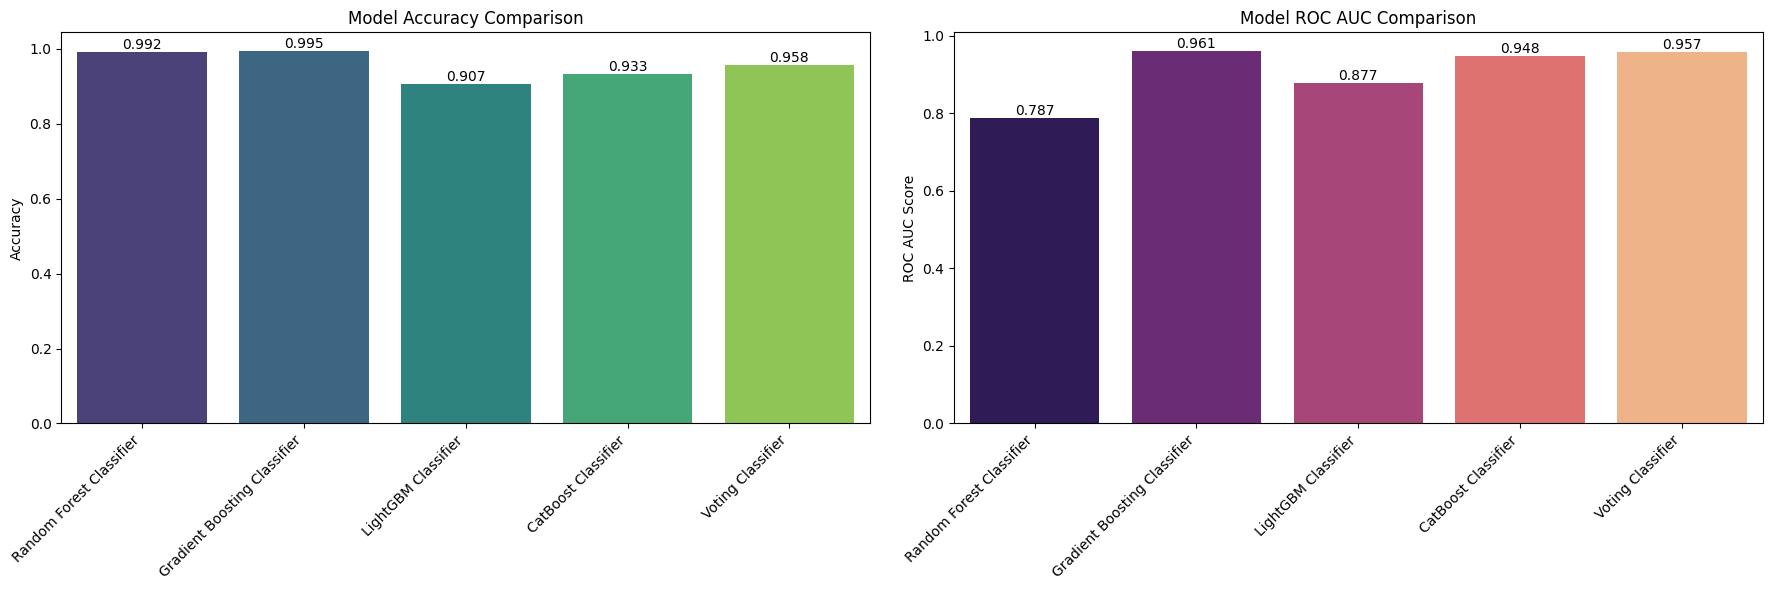

/tmp/ipython-input-3144148387.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=false_positives, ax=axes[0], palette='Reds_r')
/tmp/ipython-input-3144148387.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(model_names, rotation=45, ha='right')
/tmp/ipython-input-3144148387.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=false_negatives, ax=axes[1], palette='Blues_r')
/tmp/ipython-input-3144148387.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1]

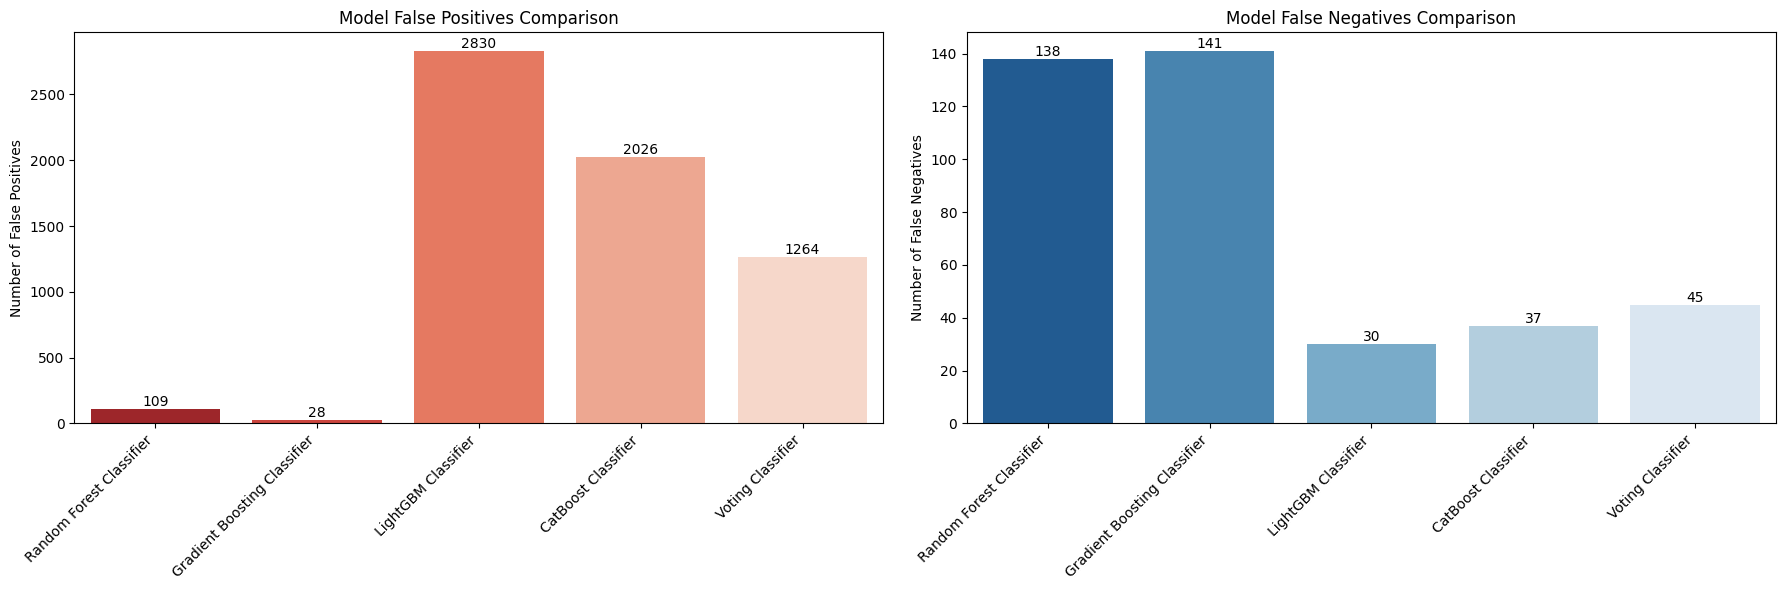

In [ ]:
# --- 4. Visualize Results (Optional but Recommended for Research) ---
print("\n" + "="*50)
print("--- Visualizing Model Comparison ---")
print("="*50)

# Ensure the Voting Classifier results are in the results dictionary
# Assuming 'voting_classifier_model' was trained and evaluated in a previous cell
# and its results (accuracy, roc_auc, confusion_matrix) are available.
# If not, you might need to re-run the training/evaluation cell for Voting Classifier.

# Re-evaluate and add Voting Classifier results to the results dictionary if needed
# This is a safeguard in case the previous cell was not run correctly or the results
# variable was overwritten.
try:
    # Check if voting_classifier_model and y_test are available
    if 'voting_classifier_model' in locals() and 'y_test' in locals() and 'X_test' in locals():
        model_name = "Voting Classifier"
        # Make predictions and evaluate for the Voting Classifier
        y_pred_vc = voting_classifier_model.predict(X_test)
        y_proba_vc = voting_classifier_model.predict_proba(X_test)[:, 1]

        accuracy_vc = accuracy_score(y_test, y_pred_vc)
        roc_auc_vc = roc_auc_score(y_test, y_proba_vc)
        cm_vc = confusion_matrix(y_test, y_pred_vc)

        results[model_name] = {
            "accuracy": accuracy_vc,
            "roc_auc": roc_auc_vc,
            "confusion_matrix": cm_vc
            # We don't need the full report for plotting, but could add it if needed
        }
        print(f"Voting Classifier results added/updated in results dictionary.")
    else:
        print("Warning: Voting Classifier model or test data not found. Skipping its inclusion in plots.")

except Exception as e:
    print(f"Error re-evaluating Voting Classifier for plotting: {e}")
    print("Skipping its inclusion in plots.")


# Prepare data for plotting
model_names = list(results.keys())
accuracy_scores = [results[name]['accuracy'] for name in model_names]
roc_auc_scores = [results[name]['roc_auc'] for name in model_names]
false_positives = [results[name]['confusion_matrix'][0, 1] for name in model_names]
false_negatives = [results[name]['confusion_matrix'][1, 0] for name in model_names]

# Convert ROC AUC scores to handle potential NaNs (e.g., from LinearSVC/SGD without predict_proba)
# We'll replace NaN with 0 for plotting purposes, or you could filter these models out.
roc_auc_scores_cleaned = [0 if np.isnan(score) else score for score in roc_auc_scores]

# Plotting Accuracy and ROC AUC
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x=model_names, y=accuracy_scores, ax=axes[0], palette='viridis')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
for index, value in enumerate(accuracy_scores):
    axes[0].text(index, value, f'{value:.3f}', ha='center', va='bottom')

sns.barplot(x=model_names, y=roc_auc_scores_cleaned, ax=axes[1], palette='magma')
axes[1].set_title('Model ROC AUC Comparison')
axes[1].set_ylabel('ROC AUC Score')
axes[1].set_xticklabels(model_names, rotation=45, ha='right')
for index, value in enumerate(roc_auc_scores_cleaned):
    axes[1].text(index, value, f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Plotting False Positives and False Negatives
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(x=model_names, y=false_positives, ax=axes[0], palette='Reds_r')
axes[0].set_title('Model False Positives Comparison')
axes[0].set_ylabel('Number of False Positives')
axes[0].set_xticklabels(model_names, rotation=45, ha='right')
for index, value in enumerate(false_positives):
    axes[0].text(index, value, str(value), ha='center', va='bottom')

sns.barplot(x=model_names, y=false_negatives, ax=axes[1], palette='Blues_r')
axes[1].set_title('Model False Negatives Comparison')
axes[1].set_ylabel('Number of False Negatives')
axes[1].set_xticklabels(model_names, rotation=45, ha='right')
for index, value in enumerate(false_negatives):
    axes[1].text(index, value, str(value), ha='center', va='bottom')


plt.tight_layout()
plt.show()

### Model Selection Rationale: Choosing the Best Algorithm

Given the highly imbalanced nature of the dataset, where KEVs (the positive class) represent a very small fraction of the total vulnerabilities, simply relying on overall accuracy for model selection can be misleading. A model could achieve high accuracy by predicting the majority class (non-KEVs) most of the time, while completely missing the critical KEVs.

For this task, the ability to correctly identify actual KEVs (high **Recall**) is paramount, even if it means accepting a certain number of false positives. However, an excessively high rate of false positives can lead to alert fatigue and reduce the effectiveness of the model in a real-world security context. Therefore, we seek a model that provides a good balance between **Recall** and a manageable number of **False Positives**, while also exhibiting a strong ability to discriminate between the classes (high **ROC AUC**).

Based on the evaluation metrics presented:

*   **Models like Decision Tree and KNN** achieved very high overall accuracy and low false positives, but their **Recall** for the KEV class was significantly low. This indicates they are likely biased towards the majority class and miss a large proportion of actual KEVs.
*   **Individual models like Logistic Regression and XGBoost** showed good **Recall** and **ROC AUC**, but also resulted in a relatively high number of **False Positives**.
*   **The Stacking Classifier**, while having high accuracy and zero false positives, demonstrated **zero Recall** for the positive class, rendering it unsuitable for identifying KEVs.
*   **Gradient Boosting and Random Forest** showed high accuracy and low false positives, but their **Recall** for KEVs was also quite low.
*   **LightGBM and CatBoost** showed better recall than Decision Tree/KNN/RF/GB, but still had a considerable number of false positives.

The **Voting Classifier**, combining Logistic Regression, XGBoost, and Random Forest with soft voting, provided a favorable trade-off. It maintained a high **ROC AUC** (0.9572) and a respectable **Recall** (0.76) for the KEV class, while significantly reducing the number of **False Positives** (1264) compared to individual high-recall models like Logistic Regression (3248) and XGBoost (2584). Although its precision for the KEV class is still relatively low, the balance it strikes between identifying a large portion of actual KEVs and keeping false alarms at a more manageable level makes it the most suitable model among those evaluated for the purpose of flagging potential KEVs from vulnerability scan data.